In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from conv1d_model import CNN1D, TrainingHarness
from utils import create_tensor, cv_split, min_max_scaling

%load_ext autoreload
%autoreload 2
%aimport numpy
%aimport torch
%aimport matplotlib.pyplot

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_df = pd.read_csv("./data/train.csv", index_col=0).drop_duplicates()
test_df = pd.read_csv("./data/test_nolabels.csv", index_col=0)

In [6]:
scaled_train_df, scaled_test_df = min_max_scaling(train_df, test_df)

In [31]:
sets = cv_split(scaled_train_df)

x_train = torch.as_tensor(create_tensor(sets[0]["train"][0]), dtype=torch.float).to(device)
y_train = torch.as_tensor(sets[0]["train"][1].to_numpy(), dtype=torch.float).to(device)

x_val = torch.as_tensor(create_tensor(sets[0]["test"][0]), dtype=torch.float).to(device)
y_val = torch.as_tensor(sets[0]["test"][1].to_numpy(), dtype=torch.float).to(device)

dataset = ((x_train, y_train), (x_val, y_val))

In [32]:
model_CNN1d = CNN1D()#.double()
model_CNN1d.to(device)

CNN1D(
  (layers4): Sequential(
    (0): Conv1d(18, 18, kernel_size=(4,), stride=(1,))
    (1): ReLU()
    (2): InstanceNorm1d(18, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (layers3): Sequential(
    (0): Conv1d(18, 18, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): InstanceNorm1d(18, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
)

In [33]:
harness = TrainingHarness(dataset=dataset, model=model_CNN1d)

In [34]:
logs = harness.train_loop(50)

100%|██████████| 50/50 [01:14<00:00,  1.48s/it]


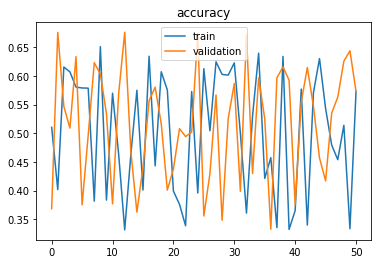

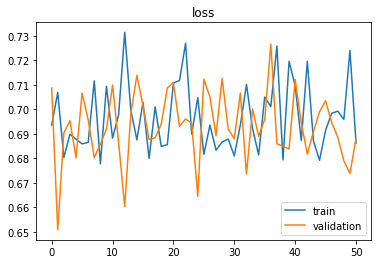

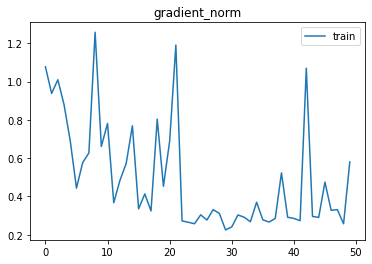

In [35]:
harness.plot_logs()

In [98]:
x_test = torch.as_tensor(create_tensor(scaled_test_df), dtype=torch.double).to(device)

In [105]:
bin_pred = harness.model(x_test).argmax(axis=1)

In [103]:
def save_pred(y, sub_id):
    original_index = test_df.index
    output_df = pd.DataFrame(y, index=original_index, columns=["LABELS"], dtype=int)
    output_df.to_csv(f"./submission/submission{sub_id}.csv")

In [106]:
save_pred(bin_pred, 4)